## Loading required packages

In [1]:
from sklearn.feature_extraction.text import HashingVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn import metrics, cluster
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA #PCA

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import string
import itertools


## Loading the data

In [3]:
# Import data

df = pd.read_csv('fake_news_dataset.csv')

In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
    df.shape

(20800, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


## Data Preperation

Dropping ID Column

In [7]:
df = df.drop(columns=['id'])

Replacing NULL values with empty string

In [8]:
df = df.fillna('')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20800 non-null  object
 1   author  20800 non-null  object
 2   text    20800 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 650.1+ KB


In [10]:
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

Combining all text data into 1 column to have our model train on all text data to increase generalisability.

In [11]:
pd.options.mode.chained_assignment = None  
df['corpus'] = df['title'] + ' ' + df['author'] + ' ' + df['text']

In [12]:
df

,title,author,text,label,corpus
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...
...,...,...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,Rapper T.I.: Trump a ’Poster Child For White S...
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,Macy’s Is Said to Receive Takeover Approach by...
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [13]:
df = df.drop(['title','author','text'], axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   20800 non-null  int64 
 1   corpus  20800 non-null  object
dtypes: int64(1), object(1)
memory usage: 325.1+ KB


In [15]:
df.head(10)

,label,corpus
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,1,Why the Truth Might Get You Fired Consortiumne...
3,1,15 Civilians Killed In Single US Airstrike Hav...
4,1,Iranian woman jailed for fictional unpublished...
5,0,Jackie Mason: Hollywood Would Love Trump if He...
6,1,Life: Life Of Luxury: Elton John’s 6 Favorite ...
7,0,Benoît Hamon Wins French Socialist Party’s Pre...
8,0,Excerpts From a Draft Script for Donald Trump’...
9,0,"A Back-Channel Plan for Ukraine and Russia, Co..."


In [16]:
df['lens'] = df['corpus'].apply(len)

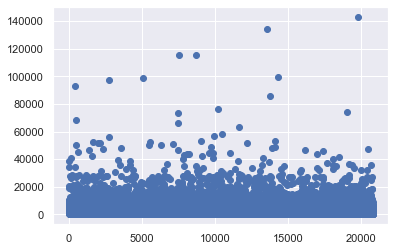

In [17]:
plt.scatter(df.index,df['lens'])

In [18]:
df['lens'].describe()

count     20800.00000
mean       4632.41024
std        5133.37673
min           8.00000
25%        1708.00000
50%        3444.00000
75%        6364.50000
max      143053.00000
Name: lens, dtype: float64

In [19]:
# Obtain top 50 most popular words

top_N = 50

# replace all non-alphanumeric characters
df['corpus_rep'] = df.corpus.str.lower().str.replace('\W', ' ')

# tokenize
df['tok'] = df.corpus_rep.apply(nltk.tokenize.word_tokenize)

In [20]:
# all tokenized words to a list
words = df.tok.tolist()  # this is a list of lists
words = [word for list_ in words for word in list_]

# frequency distribution
word_dist = nltk.FreqDist(words)

# remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords)

# output the results
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N), columns=['Word', 'Frequency'])
rslt

,Word,Frequency
0,said,80136
1,mr,66324
2,trump,59990
3,one,38909
4,would,37484
5,new,37223
6,people,36777
7,clinton,28619
8,like,26529
9,president,25727


Splitting data to training and test sets

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df.corpus, df.label, test_size=0.20, random_state=0)

In [22]:
x_train.head()

15902    Trump Reopening 9/11, Reversing Rome, in Bid t...
7375     Trump Inherits a Secret Cyberwar Against North...
4889     Sergei Shoigu: Admiral Kuznetsov Aircraft-carr...
2143     With Mass Protests, South Koreans Wield a Fami...
18373    The Most Important Primary Is ... Wait, Indian...
Name: corpus, dtype: object

In [23]:
x_test.head()

20386    Bob Dylan’s Nobel Prize: A Podcast Discussion ...
16794    Nuclear Weapons in South Korea under Discussio...
5500     Solar Storm Alert No Author October 27, 2016 S...
9398     Keith Lamont Scott Was Killed by Two Gunshot W...
4266     Tom Cotton: Paul Ryan’s Healthcare Bill Does N...
Name: corpus, dtype: object

In [24]:
y_train.head()

15902    1
7375     0
4889     1
2143     0
18373    0
Name: label, dtype: int64

In [25]:
y_test.head()

20386    0
16794    1
5500     1
9398     0
4266     0
Name: label, dtype: int64

Word stemmer to reduce words to root forms

In [26]:
stemmer = PorterStemmer()

Hashing Vectorisation

In [27]:
# Hashing Vectorizer

hashing_vectoriser = HashingVectorizer(stop_words='english', analyzer=stemmer.stem)

hashing_train = hashing_vectoriser.fit_transform(x_train)

hashing_test = hashing_vectoriser.transform(x_test)

C:\Users\edmun\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:497: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


TF-IDF Vectorisation

In [28]:
# TF-IDF Vectorizer

tfidf_vectoriser = TfidfVectorizer(stop_words='english', analyzer=stemmer.stem)

tfidf_train = tfidf_vectoriser.fit_transform(x_train)

tfidf_test = tfidf_vectoriser.transform(x_test)

Custom Function to plot confusion matrix of results

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Unsupervised Learning to identify potential inherent patterns within the dataset

Using 2 clusters to indicate fake and real news.

In [64]:
kmeans = KMeans(n_clusters=2, n_init=30)


In [65]:
hashing_clustered = kmeans.fit_predict(hashing_train)
hashing_clustered_results = metrics.accuracy_score(y_train, hashing_clustered)
hashing_clustered_results

0.49044471153846153

In [66]:
pd.DataFrame(hashing_clustered).value_counts()

1    16502
0      138
dtype: int64

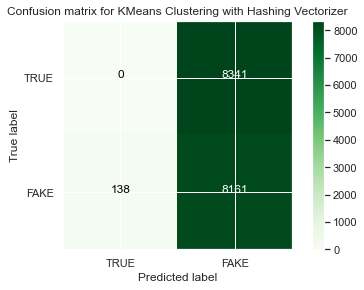

In [67]:
hashing_cm = metrics.confusion_matrix(y_train, hashing_clustered, labels=[0,1])

plot_confusion_matrix(hashing_cm, classes=['TRUE','FAKE'], title ='Confusion matrix for KMeans Clustering with Hashing Vectorizer')

In [104]:
print(classification_report(y_train, hashing_clustered))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8341
           1       0.49      0.98      0.66      8299

    accuracy                           0.49     16640
   macro avg       0.25      0.49      0.33     16640
weighted avg       0.25      0.49      0.33     16640



In [68]:
tfidf_clustered = kmeans.fit_predict(tfidf_train)
tfidf_clustered_results = metrics.accuracy_score(y_train, tfidf_clustered)
tfidf_clustered_results

0.49044471153846153

In [69]:
pd.DataFrame(tfidf_clustered).value_counts()


1    16502
0      138
dtype: int64

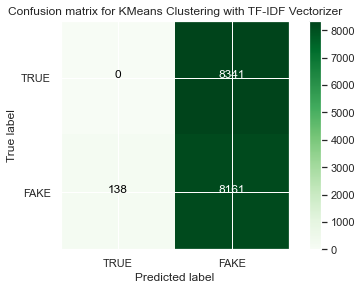

In [70]:
tfidf_cm = metrics.confusion_matrix(y_train, tfidf_clustered, labels=[0,1])

plot_confusion_matrix(tfidf_cm, classes=['TRUE','FAKE'], title ='Confusion matrix for KMeans Clustering with TF-IDF Vectorizer')

In [105]:
print(classification_report(y_train, tfidf_clustered))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8341
           1       0.49      0.98      0.66      8299

    accuracy                           0.49     16640
   macro avg       0.25      0.49      0.33     16640
weighted avg       0.25      0.49      0.33     16640



Unsupervised learning was not effective in discriminating real and fake news. There may not exist sufficient inherent patterns in news content to effectively discrimate between real and fake news.

We will utilise supervised learning tools now.

## Passive Aggressive Classifier

In [71]:
pa_classifier = PassiveAggressiveClassifier()


Applying Passive Aggressive Classifier on Hashing Vectorisation

In [72]:
# Hashing Vectorisation

hashing_pa = pa_classifier.fit(hashing_train, y_train)
hashing_pa_pred = pa_classifier.predict(hashing_test)
hashing_pa_acc = metrics.accuracy_score(y_test, hashing_pa_pred)
print("Accuracy for Passive Aggressive Classifier on Hashing Vectorisation", hashing_pa_acc)

Accuracy for Passive Aggressive Classifier on Hashing Vectorisation 0.9735576923076923


In [73]:
print(classification_report(y_test, hashing_pa_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2046
           1       0.99      0.96      0.97      2114

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



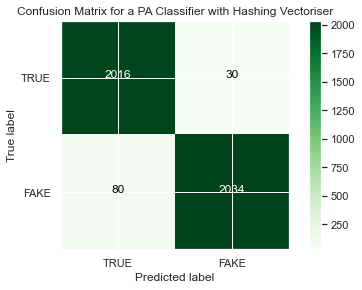

In [74]:
hashing_pa_cm = metrics.confusion_matrix(y_test, hashing_pa_pred, labels = [0,1])
plot_confusion_matrix(hashing_pa_cm, classes=['TRUE', 'FAKE'], title = 'Confusion Matrix for a PA Classifier with Hashing Vectoriser')

Applying Passive Aggressive Classifier on TF-IDF Vectorisation

In [75]:
# TF-IDF Vectorisation

tfidf_pa = pa_classifier.fit(tfidf_train, y_train)
tfidf_pa_pred = pa_classifier.predict(tfidf_test)
tfidf_pa_acc = metrics.accuracy_score(y_test, tfidf_pa_pred)
print("Accuracy for Passive Aggressive Classifier on TF-IDF Vectorisation", tfidf_pa_acc)

Accuracy for Passive Aggressive Classifier on TF-IDF Vectorisation 0.9591346153846154


In [84]:
print(classification_report(y_test, tfidf_pa_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2046
           1       1.00      0.92      0.96      2114

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



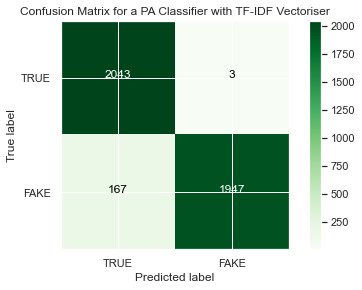

In [76]:
tfidf_pa_cm = metrics.confusion_matrix(y_test, tfidf_pa_pred, labels = [0,1])
plot_confusion_matrix(tfidf_pa_cm, classes=['TRUE', 'FAKE'], title = 'Confusion Matrix for a PA Classifier with TF-IDF Vectoriser')

Accuracy for Passive Aggressive is high at 0.981 on the test dataset. However, we notice 62 false positives, which means a high number of fake news articles are wrongly classified as real news instead. This is undesirable.

# Logistic Regression


In [77]:

logistic_reg = LogisticRegression(C=1000, max_iter=1000)   

Applying Logistic Regression Classifier on Hashing Vectorisation

In [78]:
# Hashing Vectoriser

logistic_reg.fit(hashing_train,y_train)
hashing_log_pred = logistic_reg.predict(hashing_test)
hashing_log_acc = metrics.accuracy_score(y_test,hashing_log_pred)

print("Accuracy for Logistic Regression on Hashing Vectorisation", hashing_log_acc)

Accuracy for Logistic Regression on Hashing Vectorisation 0.98125


In [86]:
print(classification_report(y_test, hashing_log_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2046
           1       0.99      0.97      0.98      2114

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



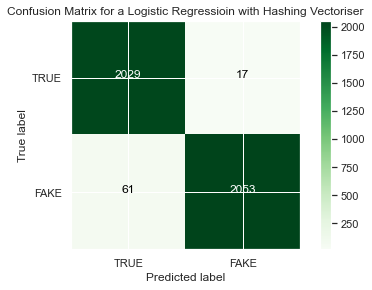

In [79]:
hashing_log_cm = metrics.confusion_matrix(y_test, hashing_log_pred, labels = [0,1])
plot_confusion_matrix(hashing_log_cm , classes=['TRUE', 'FAKE'], title = 'Confusion Matrix for a Logistic Regressioin with Hashing Vectoriser')

In [ ]:
metrics.plot_roc_curve(logistic_reg, hashing_test, hashing_log_pred)  
plt.show() 

Applying Logistic Regression Classifier on TF-IDF Vectorisation

In [80]:
# TF-IDF Vectoriser

logistic_reg.fit(tfidf_train,y_train)
tfidf_log_pred = logistic_reg.predict(tfidf_test)
tfidf_log_acc = metrics.accuracy_score(y_test,tfidf_log_pred)

print("Accuracy for Logistic Regression on TF-IDF Vectorisation", tfidf_log_acc)

Accuracy for Logistic Regression on TF-IDF Vectorisation 0.9865384615384616


In [85]:
print(classification_report(y_test, tfidf_log_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2046
           1       0.99      0.98      0.99      2114

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



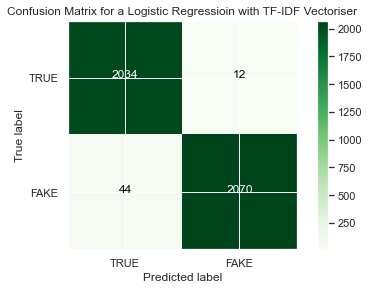

In [81]:
tfidf_log_cm = metrics.confusion_matrix(y_test, tfidf_log_pred, labels = [0,1])
plot_confusion_matrix(tfidf_log_cm , classes=['TRUE', 'FAKE'], title = 'Confusion Matrix for a Logistic Regressioin with TF-IDF Vectoriser')

The accuracy for the Logistic Regression model is higher as compared to the passive agressive model. However, a false positive of 44 is still considered high.

## XGBoost Classifier

In [29]:
import xgboost

xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')


Applying XGBoost Classifier on Hashing Vectorisation

In [87]:

xgb.fit(hashing_train,y_train)
hashing_xgb_pred = xgb.predict(hashing_test)
hashing_xgb_acc = metrics.accuracy_score(y_test,hashing_xgb_pred)

print("Accuracy for XGBoost Classifier on Hashing Vectorisation", hashing_xgb_acc)

Accuracy for XGBoost Classifier on Hashing Vectorisation 0.9973557692307692


In [92]:
print(classification_report(y_test, hashing_xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2046
           1       1.00      1.00      1.00      2114

    accuracy                           1.00      4160
   macro avg       1.00      1.00      1.00      4160
weighted avg       1.00      1.00      1.00      4160



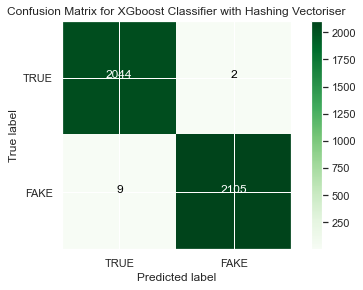

In [88]:
hashing_xgb_cm = metrics.confusion_matrix(y_test, hashing_xgb_pred, labels = [0,1])
plot_confusion_matrix(hashing_xgb_cm , classes=['TRUE', 'FAKE'], title = 'Confusion Matrix for XGboost Classifier with Hashing Vectoriser')

Applying XGBoost Classifier on TF-IDF Vectorisation

In [30]:
xgb.fit(tfidf_train,y_train)
tfidf_xgb_pred = xgb.predict(tfidf_test)
tfidf_xgb_acc = metrics.accuracy_score(y_test,tfidf_xgb_pred)

print("Accuracy for XGBoost Classifier on TF-IDF Vectorisation", tfidf_xgb_acc)

Accuracy for XGBoost Classifier on TF-IDF Vectorisation 0.9978365384615384


In [34]:
tfidf_xgb_pred_proba = xgb.predict_proba(tfidf_test)

In [37]:
tfidf_xgb_pred_proba 

array([0, 1, 1, ..., 0, 1, 1])

In [36]:
tfidf_xgb_pred

array([[9.9994266e-01, 5.7350226e-05],
       [2.2649765e-06, 9.9999774e-01],
       [7.9158545e-03, 9.9208415e-01],
       ...,
       [9.9998498e-01, 1.5003413e-05],
       [4.7564507e-05, 9.9995244e-01],
       [3.1493306e-03, 9.9685067e-01]], dtype=float32)

In [31]:
print(classification_report(y_test, tfidf_xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2046
           1       1.00      1.00      1.00      2114

    accuracy                           1.00      4160
   macro avg       1.00      1.00      1.00      4160
weighted avg       1.00      1.00      1.00      4160



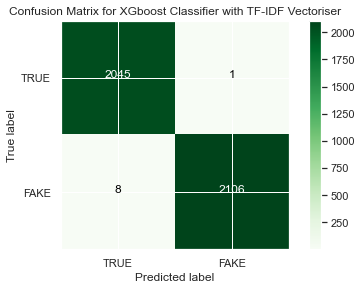

In [32]:
tfidf_xgb_cm = metrics.confusion_matrix(y_test, tfidf_xgb_pred, labels = [0,1])
plot_confusion_matrix(tfidf_xgb_cm , classes=['TRUE', 'FAKE'], title = 'Confusion Matrix for XGboost Classifier with TF-IDF Vectoriser')

XGBoost showed the highest accuracy among the 3 models. Specifically, TF-IDF Vectorisation of the text data resulted in slightly higher accuracy as compared to Hashing Vectorisation.